## Cluster comparison

This notebook compares the test partition of OQMD data against the CoRE MOF dataset.
This is meant to evaluate how similar those two groups are and give us an idea of
how much faith we can put in to the models trained solely on OQMD data. Samples
are first scaled using a StandardScaler fit to the OQMD training set. This mimics
the machine learning pipeline as closely as possible.

We use Silhouette Score here. It compares a samples intra-cluster distance to 
the mean nearest-cluster distance. In other words, for each sample, it compares the 
distance of a sample to its assigned cluster and the nearest cluster it was not
assigned to.

The best value is 1, which means that samples are very close to its assigned cluster
and very far from other clusters. The worst value is -1, which means that
each sample is closer to a a cluster other than its assigned cluster.

More details here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

We wish to observe low silhouette scores, near 0. This means that
samples are mixed and the clusters are not very distinct. In the wiki article, 
https://en.wikipedia.org/wiki/Silhouette_(clustering), it says that below 0.2 
is weak.

We compare this to the silhouette score between training and test sets of
random and similarity splits.

Basically, as silhoutte score goes up, model performance will go down.


In [1]:
import sklearn.decomposition as decomp
import sklearn.preprocessing as prep
import sklearn.metrics as metrics
import sklearn.impute as impute
import seaborn as sns
import pandas as pd
import numpy as np

import simple_featurizer as sf
import screen
import warnings

warnings.filterwarnings('ignore', message="^Columns.*")
def plot_clusters(group1, group1_name, group2, group2_name, scaler, decomp_method, title):
    both_df = pd.concat([group1, group2])
    X = scaler.transform(both_df)
    both_df['group_name'] = [group1_name]*len(group1)+[group2_name]*len(group2)

    # using 70 features sometimes results in nan values
    imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(X)

    X_prime = decomp_method(n_components=2).fit_transform(X)
    X_prime_df = pd.DataFrame(data={'Dimension 1':X_prime[:,0], 'Dimension 2':X_prime[:,1], 'Group':both_df['group_name']})

    ax = sns.scatterplot(data=X_prime_df, x='Dimension 1', y='Dimension 2', hue='Group', alpha=.3)
    ax.set_title(title)

    return X

def load_all_compounds(csv_path):
    all_df = pd.read_csv(csv_path, dtype={'id':str})

    feature_cols = sf.get_feature_columns(all_df.columns)

    oqmd = all_df[(all_df['label']=='conducting') | (all_df['label']=='non-conducting')]
    core_mof = all_df[all_df['label']=='unknown']

    keep = [screen.element_filter(formula) for formula in core_mof['chemical_formula']]
    core_mof = core_mof[keep]


    assert len(oqmd)+len(core_mof) == len(all_df)

    return oqmd[feature_cols], core_mof[feature_cols]

def load_oqmd_compounds(csv_path):
    all_df = pd.read_csv(csv_path, dtype={'id':str}, low_memory=False)

    feature_cols = sf.get_feature_columns(all_df.columns)

    return all_df[feature_cols]

def evaluate(num_features):
    assert num_features==44 or num_features==70

    train = load_oqmd_compounds(f'../data/query_files9/random_train_df_{num_features}_nodup.csv')
    feature_cols = sf.get_feature_columns(train.columns)
    scaler = prep.StandardScaler().fit(train[feature_cols])

    test = load_oqmd_compounds(f'../data/query_files9/random_test_df_{num_features}_nodup.csv')

    oqmd, coremof = load_all_compounds(f'../data/{num_features}_withcols_all_compounds.csv')

    X = plot_clusters(test, 'OQMD Test', coremof, 'CoREMOF', decomp_method=decomp.PCA, scaler=scaler, title=f'{num_features} feature OQMD Randomly Split Test vs CoREMOF PCA plot')
    sil_score = metrics.silhouette_score(X, labels=['oqmd']*len(test)+['coremof']*len(coremof), random_state=0)
    print(f'silhouette score {sil_score:0.4f}')

def evaluate_similarity_split_coremof(num_features):
    assert num_features==44 or num_features==70

    train = load_oqmd_compounds(f'../data/query_files9/similarity_train_df_{num_features}_nodup.csv')
    feature_cols = sf.get_feature_columns(train.columns)
    scaler = prep.StandardScaler().fit(train[feature_cols])

    test = load_oqmd_compounds(f'../data/query_files9/similarity_test_df_{num_features}_nodup.csv')

    oqmd, coremof = load_all_compounds(f'../data/{num_features}_withcols_all_compounds.csv')

    X = plot_clusters(test, 'OQMD Test', coremof, 'CoREMOF', decomp_method=decomp.PCA, scaler=scaler, title=f'{num_features} feature OQMD Similarity Split Test vs CoREMOF PCA plot')
    sil_score = metrics.silhouette_score(X, labels=['oqmd']*len(test)+['coremof']*len(coremof), random_state=0)
    print(f'silhouette score {sil_score:0.4f}')

def evaluate_split(num_features, split):
    assert num_features==44 or num_features==70

    train = load_oqmd_compounds(f'../data/query_files9/{split}_train_df_{num_features}_nodup.csv')
    feature_cols = sf.get_feature_columns(train.columns)
    scaler = prep.StandardScaler().fit(train[feature_cols])

    test = load_oqmd_compounds(f'../data/query_files9/{split}_test_df_{num_features}_nodup.csv')

    X = plot_clusters(test, 'OQMD Test', train, 'OQMD Train', decomp_method=decomp.PCA, scaler=scaler, title=f'{num_features} feature, OQMD Train vs OQMD Test, {split} split, PCA plot')

    sil_score = metrics.silhouette_score(X, labels=['test']*len(test)+['train']*len(train), random_state=0)
    print(f'silhouette score {sil_score:0.4f}')


def evaluate_oqmd_vs_coremof(num_features):
    oqmd, coremof = load_all_compounds(f'../data/{num_features}_withcols_all_compounds.csv')
    feature_cols = sf.get_feature_columns(oqmd.columns)
    scaler = prep.StandardScaler().fit(oqmd[feature_cols])

    X = plot_clusters(oqmd, 'OQMD', coremof, 'CoRE MOF', decomp_method=decomp.PCA, scaler=scaler, title=f'{num_features} feature, OQMD vs CoRE MOF PCA plot')

    sil_score = metrics.silhouette_score(X, labels=['a']*len(oqmd)+['b']*len(coremof), random_state=0)
    print(f'silhouette score {sil_score:0.4f}')




silhouette score 0.2138


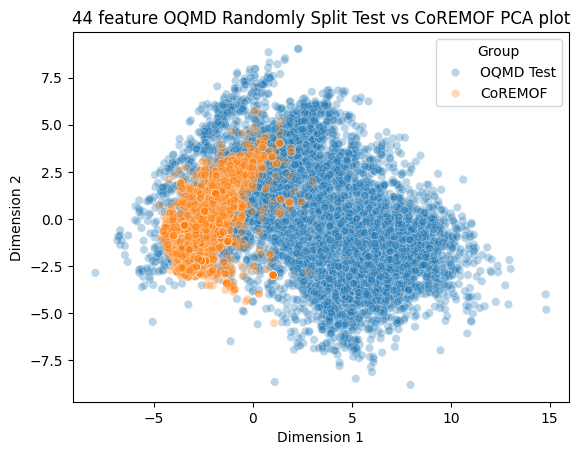

In [2]:
evaluate(44)

silhouette score 0.2679


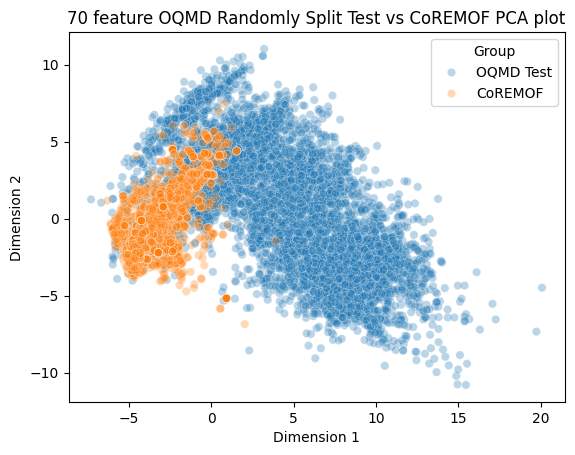

In [3]:
evaluate(70)

silhouette score 0.1652


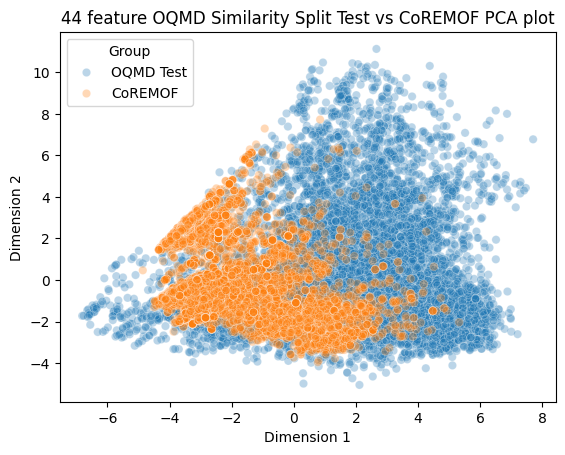

In [4]:
evaluate_similarity_split_coremof(44)

silhouette score 0.2457


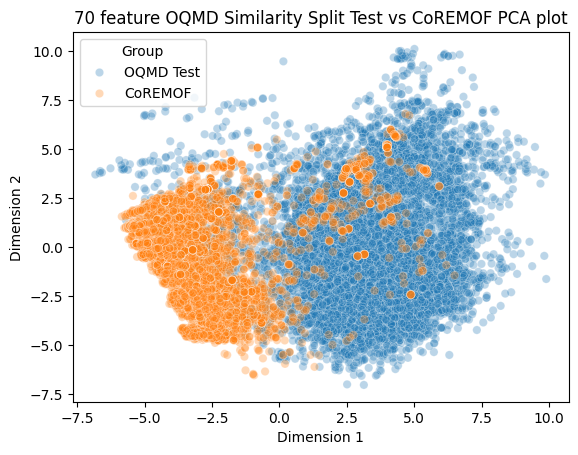

In [5]:
evaluate_similarity_split_coremof(70)

silhouette score 0.0008


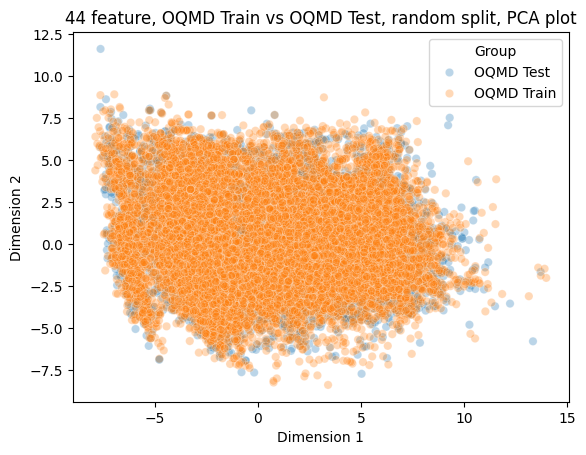

In [6]:
evaluate_split(44, 'random')

silhouette score 0.0005


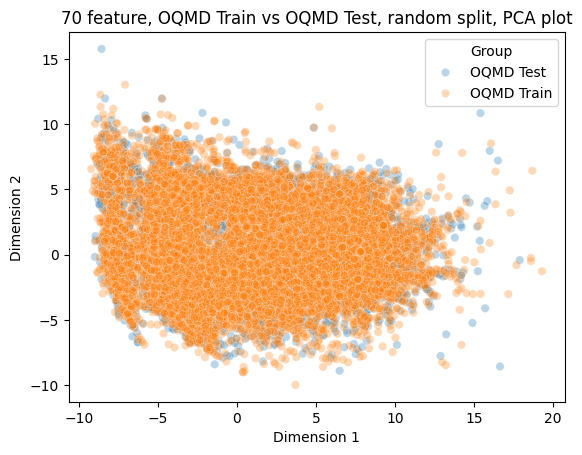

In [7]:
evaluate_split(70, 'random')

silhouette score 0.1342


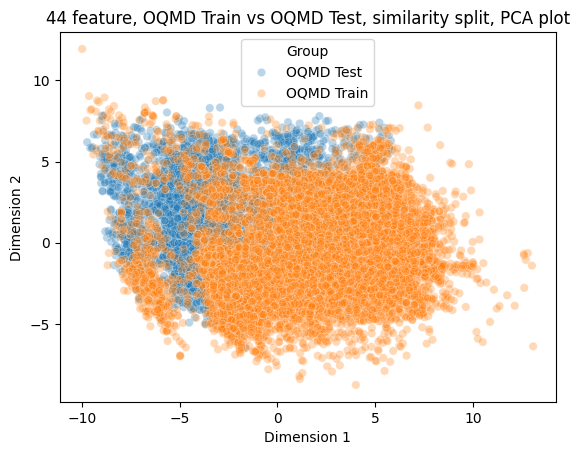

In [8]:
evaluate_split(44, 'similarity')

silhouette score 0.1155


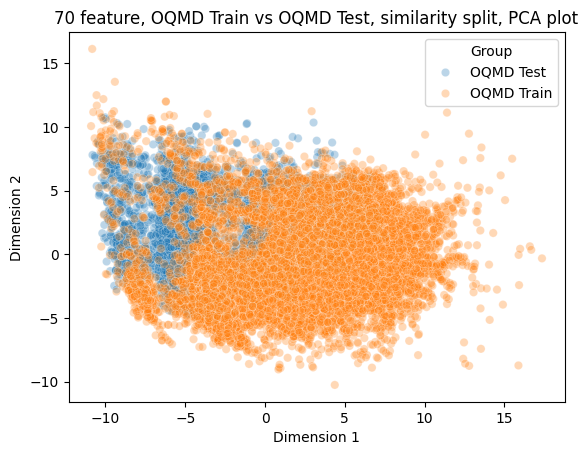

In [9]:
evaluate_split(70, 'similarity')


silhouette score 0.0917


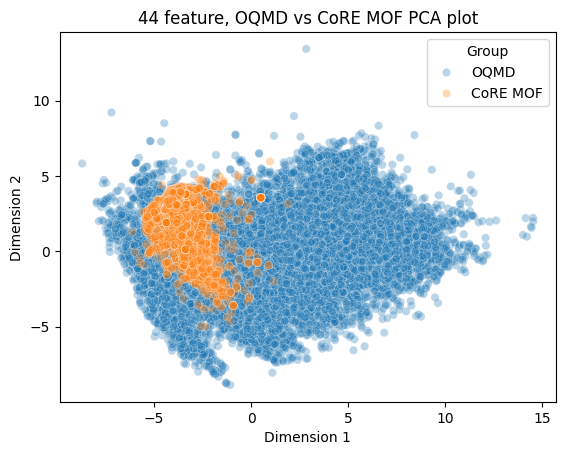

In [10]:
evaluate_oqmd_vs_coremof(44)

silhouette score 0.1463


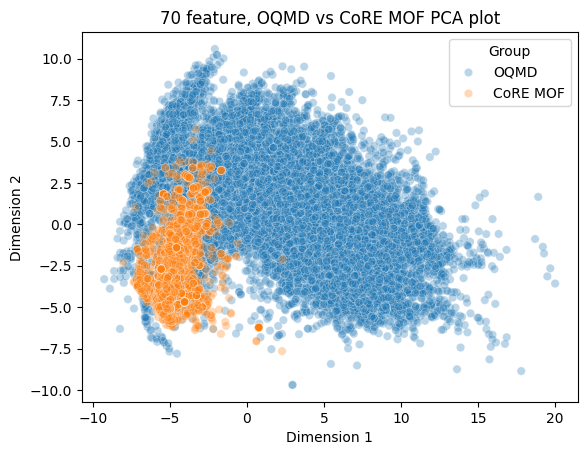

In [11]:
evaluate_oqmd_vs_coremof(70)